In [1]:
!pip install -qU pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from kan import *

In [3]:
# Load Data
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Data Preprocessing
def preprocess(df):
    df = df.select_dtypes(include=[np.number])  # Select only numerical columns
    df.fillna(df.median(), inplace=True)  # Fill missing values with median
    return df

train_data = preprocess(train.drop(columns=['Id', 'SalePrice']))
test_data = preprocess(test.drop(columns=['Id']))
y = train['SalePrice'].values
X_train, X_val, y_train, y_val = train_test_split(train_data, y, test_size=0.2, random_state=42)

In [6]:
# Normalize
def normalize(X_train, X_val, test_data):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    test_data = scaler.transform(test_data)
    return X_train, X_val, test_data

X_train, X_val, test_data = normalize(X_train, X_val, test_data)

In [7]:
# Initialize KAN
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KAN(width=[X_train.shape[1], 10, 5, 1], grid=3, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [8]:
# Training the Model
model.fit({'train_input': torch.tensor(X_train, dtype=torch.float64, device=device),
           'train_label': torch.tensor(y_train, dtype=torch.float64, device=device).view(-1, 1),
           'test_input': torch.tensor(X_val, dtype=torch.float64, device=device),
           'test_label': torch.tensor(y_val, dtype=torch.float64, device=device).view(-1, 1)},
          opt="LBFGS", steps=100, lamb=0.001)

| train_loss: 7.71e+03 | test_loss: 3.99e+04 | reg: 2.17e+03 | : 100%|█| 100/100 [02:57<00:00,  1.77

saving model version 0.1


{'train_loss': [array(40540.73737613),
  array(27113.15374201),
  array(25491.04104554),
  array(23389.53862839),
  array(22055.81232287),
  array(20245.83883186),
  array(18947.96446639),
  array(18203.62625093),
  array(17577.66215127),
  array(16916.97898485),
  array(16838.39790691),
  array(16322.42929951),
  array(15837.55911986),
  array(15337.33796438),
  array(14974.64808295),
  array(14850.78272218),
  array(14492.94479228),
  array(14186.60506776),
  array(13850.01590479),
  array(13610.24419102),
  array(13569.25818475),
  array(13237.72395842),
  array(12944.79023046),
  array(12694.53276541),
  array(12442.11903074),
  array(12387.12945147),
  array(12054.91456232),
  array(11805.91180164),
  array(11594.94517985),
  array(11432.06027325),
  array(11407.5156684),
  array(11253.74151237),
  array(11137.1700822),
  array(10981.62068612),
  array(10848.54245161),
  array(10830.65908923),
  array(10726.81003413),
  array(10628.87400659),
  array(10493.57047572),
  array(10389

In [9]:
# Extract Symbolic Formula
mode = "auto"
if mode == "manual":
    model.fix_symbolic(0, 0, 0, 'sin')
    model.fix_symbolic(0, 1, 0, 'x^2')
    model.fix_symbolic(1, 0, 0, 'exp')
elif mode == "auto":
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.0538291291087817, c=1
fixing (0,0,1) with x^2, r2=0.97427438302219, c=2
fixing (0,0,2) with x, r2=0.9799090851936811, c=1
fixing (0,0,3) with x^2, r2=0.9817699352984808, c=2
fixing (0,0,4) with x^2, r2=0.9942622981703721, c=2
fixing (0,0,5) with exp, r2=0.9764888578969383, c=2
fixing (0,0,6) with sin, r2=0.9999501474522381, c=2
fixing (0,0,7) with sin, r2=0.9520060582810473, c=2
fixing (0,0,8) with sin, r2=0.9997050840405811, c=2
fixing (0,0,9) with x, r2=0.5063150847808671, c=1
fixing (0,1,0) with sin, r2=0.9674434496913555, c=2
fixing (0,1,1) with sin, r2=0.9971047066361599, c=2
fixing (0,1,2) with x, r2=0.3513722016134106, c=1
fixing (0,1,3) with sin, r2=0.9978461448807731, c=2
fixing (0,1,4) with x, r2=0.9415687963473504, c=1
fixing (0,1,5) with sin, r2=0.983414458125902, c=2
fixing (0,1,6) with sin, r2=0.9961264083653001, c=2
fixing (0,1,7) with sin, r2=0.9991331947841279, c=2
fixing (0,1,8) with x, r2=0.06261815564678123, c=1
fixing (0,1,9) with sin, r

In [10]:
# Output Final Symbolic Formula
from kan.utils import ex_round
final_formula = ex_round(model.symbolic_formula()[0][0], 4)
print("Final Model Formula:", final_formula)

Final Model Formula: 672.8621*x_1 + 2539.5214*x_10 + 3372.1054*x_11 + 3107.2713*x_12 + 3745.5079*x_13 + 1059.8302*x_14 - 9014.5935*x_15 + 29145.5418*x_16 - 5019.6479*x_17 - 1063.5486*x_18 - 4969.2425*x_2 + 601.29*x_21 - 1514.112*x_22 - 1084.7877*x_23 - 3179.5503*x_24 - 12048.6017*x_25 + 4922.304*x_26 + 3815.8991*x_27 + 2360.8073*x_28 - 525.6528*x_29 + 1170.9468*x_3 + 7277.5025*x_30 - 3539.8556*x_31 + 2740.3378*x_32 - 8011.7739*x_33 + 85.3738*x_34 + 7118.3266*x_35 + 1871.3379*x_36 + 2818.7611*x_4 + 5155.717*x_5 - 9311.8022*x_6 + 1861.4376*x_7 - 5846.5197*x_8 + 1589.7794*x_9 - 5957.6677*(0.1741 - x_26)**2 + 773.5675*(0.8159 - x_20)**2 - 624.1036*(1 - 0.9352*x_1)**2 + 8628.9628*(1 - 0.7666*x_1)**2 + 16285.5344*(1 - 0.7459*x_1)**2 + 32510.7071*(1 - 0.1074*x_15)**2 + 3197.7472*(1 - 0.9464*x_17)**2 - 6254.0254*(1 - 0.2014*x_17)**2 - 22558.6887*(1 - 0.0826*x_17)**2 - 22622.784*(1 - 0.0915*x_18)**2 + 145056.6397*(1 - 0.029*x_18)**2 - 13069.2929*(1 - 0.2132*x_20)**2 - 10999.3987*(1 - 0.0675*x_2

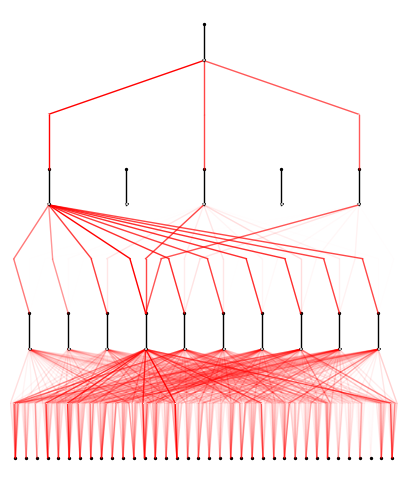

In [11]:
# Visualize KAN
model.plot()

In [12]:
# Predictions
test_preds = model(torch.tensor(test_data, dtype=torch.float64, device=device)).cpu().detach().numpy()

In [13]:
# Submission
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': test_preds.ravel()})
submission.to_csv('kan_housing_submission.csv', index=False)